# Oppgave 1

In [26]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
from time import time

import xarray as xr
from scipy.interpolate import RectBivariateSpline

import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

#Oppgave 1a)
#Defining params

A = 0.1
epsilon = 0.25
omega = 1

In [68]:
# Defining given functions

def a(t):
    return epsilon * np.sin(omega * t)

def b(t):
    return 1 - 2 * epsilon * np.sin(omega * t)

def f_a(x, t):
    return a(t) * x**2 + b(t) * x

def fDelX(x, t):
    return 2 * a(t) * x + b(t)

def vX(x, y, t):
    return -np.pi * A * np.sin(np.pi * f_a(x, t)) * np.cos(np.pi * y)

def vY(x, y, t):
    return np.pi * A * np.cos(np.pi * f_a(x, t)) * np.sin(np.pi * y) * fDelX(x, t)


def coordDerived(coords, t):
    xs = coords[0,:]
    ys = coords[1,:]
    return np.array([vX(xs, ys, t), vY(xs, ys, t)])

In [69]:
# Giving initial value to the coordinates-array

import matplotlib.pyplot as plt

h = 0.01

def Heun(h, tEnd, initPos, f):
    tList = np.arange(0, tEnd, h)

    coordArr = np.zeros((initPos.shape[0],initPos.shape[1],len(tList)))
    # xCoordArr, yCoordArr = np.zeros(len(tList)), np.zeros(len(tList))
    coordArr[:,:,0] = initPos

    for i in range(1, len(tList)):
        coordI = coordArr[:,:,i-1]
        # print(coordI.shape)
        ti = tList[i-1]
        k1 = f(coordI, ti)
        # tempCoord = np.array([coordI[0] + k1[0]*h, coordI[1] + k1[1]*h])
        tempCoord = coordI + k1*h
        # print(f"tem.shape: {tempCoord.shape}")

        k2 = f(tempCoord, ti + h)
        # nextXCoord = coordI[0] + h/2*(k1[0] + k2[0])
        # nextYCoord = coordI[1] + h/2*(k1[1] + k2[1])
        # coordArr[i] = np.array([nextXCoord, nextYCoord])
        coordArr[:,:,i] = coordI +h/2*(k1 + k2)

    # for i in range(0, len(tList)):
    #     xCoordArr[i] = coordArr[i][0]
    #     yCoordArr[i] = coordArr[i][1]

    return coordArr



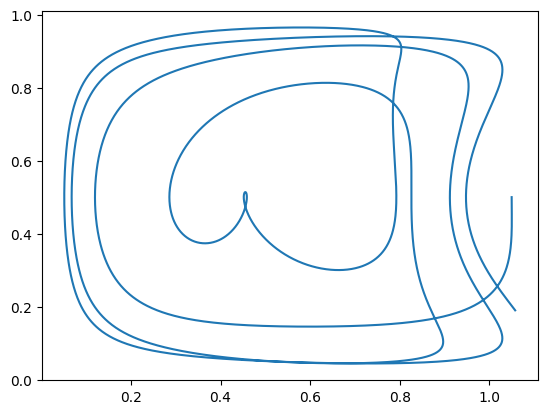

In [71]:
particles = np.zeros((2,1))
particles[0:,] = 1.05
particles[1:,] = 0.5
trajectory = Heun(h, 50, particles, coordDerived)
plt.plot(trajectory[0,0,:], trajectory[1,0,:])

In [52]:
#2a
#################################################
#### Convenience class for reading datafiles ####
#################################################

class Interpolator():
    def __init__(self, dataset, fw = 0.03):
        # xarray dataset object
        self.dataset = dataset
        # Windage factor
        self.fw = fw
        # Extract timestamps as number of seconds after the start of the file
        # Saves a bit of bother with dealing with np.datetime objects elsewhere
        self.times = np.array([(t - d.time[0])/np.timedelta64(1, 's') for t in d.time[:]], dtype=np.float64)
        self.depth = np.array(self.dataset.h)
        
    def get_interpolators(self, X, it):
        # Add a buffer of cells around the extent of the particle cloud
        buf  = 10
        # Find extent of particle cloud in terms of indices
        imax = np.searchsorted(self.dataset.X, np.amax(X[0,:])) + buf
        imin = np.searchsorted(self.dataset.X, np.amin(X[0,:])) - buf
        jmax = np.searchsorted(self.dataset.Y, np.amax(X[1,:])) + buf
        jmin = np.searchsorted(self.dataset.Y, np.amin(X[1,:])) - buf
        # Take out subset of array, to pass to
        # interpolation object
        # Fill NaN values (land cells) with 0, otherwise
        # interpolation won't work
        u_current = self.dataset.u[it, 0, jmin:jmax, imin:imax].T.fillna(0.0)
        v_current = self.dataset.v[it, 0, jmin:jmax, imin:imax].T.fillna(0.0)
        u_wind    = self.dataset.Uwind[it, jmin:jmax, imin:imax].T.fillna(0.0)
        v_wind    = self.dataset.Vwind[it, jmin:jmax, imin:imax].T.fillna(0.0)
        # RectBivariateSpline essentially returns a function,
        # which can be called to get value at arbitrary position
        fu_current = RectBivariateSpline(self.dataset.X[imin:imax], self.dataset.Y[jmin:jmax], u_current)
        fv_current = RectBivariateSpline(self.dataset.X[imin:imax], self.dataset.Y[jmin:jmax], v_current)
        fu_wind    = RectBivariateSpline(self.dataset.X[imin:imax], self.dataset.Y[jmin:jmax], u_wind)
        fv_wind    = RectBivariateSpline(self.dataset.X[imin:imax], self.dataset.Y[jmin:jmax], v_wind)
        return fu_current, fv_current, fu_wind, fv_wind
    
    def get_time_index(self, t):
        # Get index of largest timestamp smaller than (or equal to) t
        return np.searchsorted(self.times, t, side='right') - 1
    
    def on_land(self, X):
        # Find indices for each particle
        ix_list = np.searchsorted(self.dataset.X, X[0,:])
        iy_list = np.searchsorted(self.dataset.Y, X[1,:])
        # Identify which particles are in cells with depth 5
        # (which for some reason is the smallest depth)
        return np.array([self.depth[iy,ix] == 5.0 for ix, iy in zip(ix_list, iy_list)])

    def __call__(self, X, t):
        # get index of current time in dataset
        it = self.get_time_index(t)
        # get interpolating functions,
        # covering the extent of the particle
        fu_current, fv_current, fu_wind, fv_wind = self.get_interpolators(X, it)
        # Evaluate velocity at position(x[:], y[:])
        dx = fu_current(X[0,:], X[1,:], grid = False) + self.fw*fu_wind(X[0,:], X[1,:], grid = False)
        dy = fv_current(X[0,:], X[1,:], grid = False) + self.fw*fv_wind(X[0,:], X[1,:], grid = False)
        return np.array([dx, dy])
    

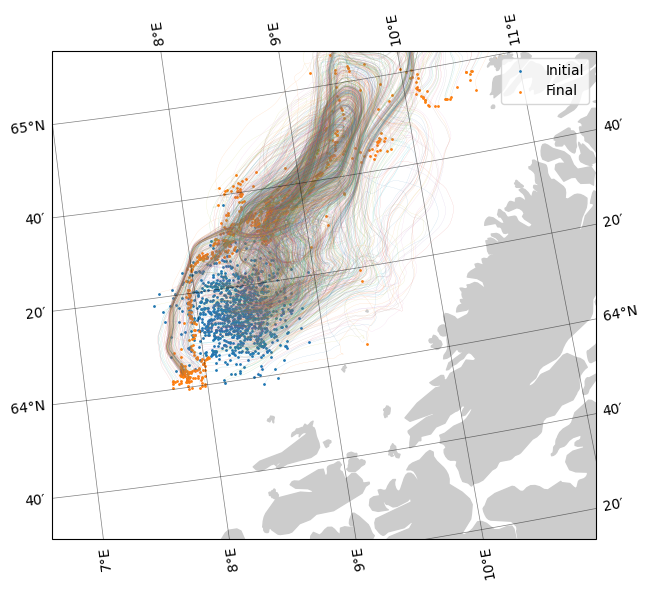

In [82]:
# Update the file path to where you put the downloaded file
d  = xr.open_dataset('data/NorKyst-800m.nc')
# Initialise the interpolator object with the data
f  = Interpolator(dataset = d, fw =0.03)

fig = plt.figure(figsize=(9,6))
ax = plt.axes(projection=ccrs.NorthPolarStereo())

ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m', color = '#cccccc'))

# Create projection object for converting particle positions
npstere = ccrs.Stereographic(
    central_latitude = 90,
    central_longitude = f.dataset.projection_stere.straight_vertical_longitude_from_pole,
    false_easting = f.dataset.projection_stere.false_easting,
    false_northing = f.dataset.projection_stere.false_northing,
    true_scale_latitude = f.dataset.projection_stere.standard_parallel,
)

# create some positions
mean_x = 790000
mean_y = 490000
standard_dev = 10000

Np = 1000
X = np.zeros((2, Np))
X[0,:] = np.random.normal(loc = mean_x, scale = standard_dev, size = Np)
X[1,:] = np.random.normal(loc = mean_y, scale = standard_dev, size = Np)

E = np.zeros((2,Np))

E = Heun(3600,3600*5*24,X, f)
# scatter plot positions, note the extra transform keyword
ax.scatter(X[0,:], X[1,:], s=1, transform=npstere, label='Initial')
for i in range(Np):
    ax.plot(E[0,i,:],E[1,i,:], transform=npstere, lw=0.1, alpha=0.5)
ax.scatter(E[0,:,-1], E[1,:,-1], s=1, transform=npstere, label='Final')



# Make outline a bit larger
ax.set_extent((7, 11, 63.5, 65))
#ax.set_extent((2, 7, 60, 61.5))
# Add gridlines
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, alpha=.5, color='k', lw=.5, )

ax.legend()
plt.tight_layout()